In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset

not_swan_default_modules = ["shap","coloredlogs"]
for name in not_swan_default_modules:
    if not name in sys.modules:
        !pip install --user name

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [2]:
train, valid, test = load_dataset(creator=ECG200(), data_path=Path(api_dir) / "src/datasets/ECG200")

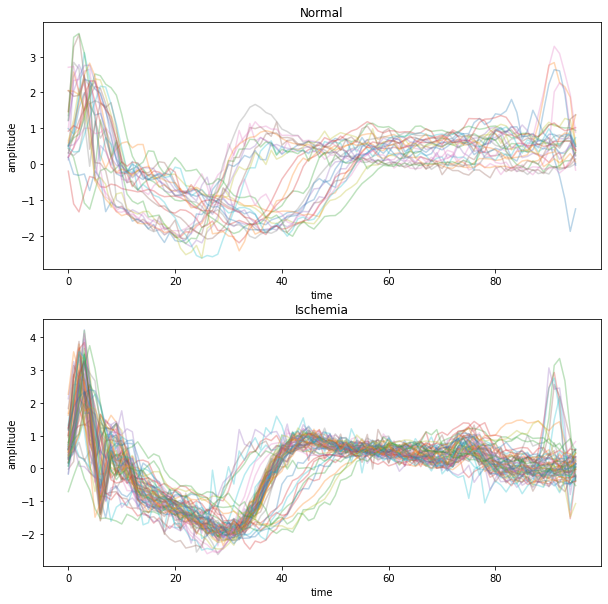

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Classify heartbeats

In [4]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

In [5]:
# define and fit classifier
clf = Classifier(input_shape=train.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)
clf.fit_classifier(train, valid)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
6/6 [==============================] - 7s 372ms/step - loss: 0.6931 - tp: 49.0000 - fp: 41.0000 - tn: 49.0000 - fn: 41.0000 - accuracy: 0.5444 - precision: 0.5444 - recall: 0.5444 - auc: 0.5107 - prc: 0.5175 - val_loss: 0.6763 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.8100 - val_prc: 0.8379
Epoch 2/500
6/6 [==============================

In [6]:
# make predictions
y_pred = clf.model.predict(x=test.X)

In [7]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 20ms/step - loss: 1.1382 - tp: 87.0000 - fp: 13.0000 - tn: 87.0000 - fn: 13.0000 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9043 - prc: 0.8842


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.138222,87.0,13.0,87.0,13.0,0.87,0.87,0.87,0.9043,0.884162


# Explain classification

In [8]:
is_correct_classification = (y_pred.argmax(axis=1) == test.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                 model=clf.model,
                                 X_reference=train.X,
                                 X_to_explain=test.X[is_correct_classification, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [9]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_title("Explanations of Classifications")
    ax.legend(["mean normal","mean ischemia"])

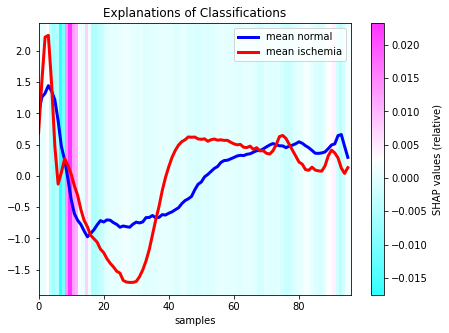

In [11]:
plot_importance(X_to_explain = test.X, y_pred = y_pred, explanation = ex_classification)